In [1]:
import os
path = os.getcwd()
path

'/home/dyna/Documents/sawada/debate_score'

In [2]:
# roberta_linear_test
## import module

import random
import numpy as np
from transformers import RobertaConfig, RobertaModel, RobertaTokenizer
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.tensorboard import SummaryWriter
from keras.preprocessing import sequence
from matplotlib import pyplot as plt
import set_debates


Using TensorFlow backend.


In [3]:
# cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
## speech, score set

microchip_debate = "./topic/microchip/debates.txt"
microchip_order = "./topic/microchip/orders.txt"
microchip_score = "./topic/microchip/scores.txt"
part_job_debate = "./topic/part-time-job/debates.txt"
part_job_order = "./topic/part-time-job/orders.txt"
part_job_score = "./topic/part-time-job/scores.txt"
four_work_debate = "./topic/four-day-work/debates.txt"
four_work_order = "./topic/four-day-work/orders.txt"
four_work_score = "./topic/four-day-work/scores.txt"

# microchip_speech
Mdebate_lists = set_debates.set_speech_list(microchip_debate,microchip_order)
Mspeeches_list = set_debates.flatten(Mdebate_lists)
# microchip_score
with open(microchip_score, 'r') as h:
    scores = h.read()
    Mscore_list = [float(s) for s in scores.split()]

# part_job_speech
Pdebate_lists = set_debates.set_speech_list(part_job_debate,part_job_order)
Pspeeches_list = set_debates.flatten(Pdebate_lists)
# part_job_score
with open(part_job_score, 'r') as h:
    scores = h.read()
    Pscore_list = [float(s) for s in scores.split()]

# four-work_speech
Fdebate_lists = set_debates.set_speech_list(four_work_debate, four_work_order)
Fspeeches_list = set_debates.flatten(Fdebate_lists)
# four-work_score
with open(four_work_score, 'r') as h:
    scores = h.read()
    Fscore_list = [float(s) for s in scores.split()]
    
# check    
len(Mspeeches_list)

50

In [5]:
## prepare inputs

def roberta_encode(speeches_list):
    # tokenizer
    tokenizer = RobertaTokenizer.from_pretrained("roberta-large")
    # token
    speech_tokens = list(
        map(
            lambda t: tokenizer.tokenize(t)[:511], speeches_list
        )
    )
    # encode   -ids
    speech_ids = list(
        map(
            lambda t: tokenizer.encode(t, add_special_tokens=True), speech_tokens
        )
    )
    # 要素の大きさを512に　つめる
    speech_ids = sequence.pad_sequences(
        speech_ids, maxlen=512, truncating='post', padding='post', dtype='int'
    )
    return speech_ids

Mspeech_ids = roberta_encode(Mspeeches_list)
Pspeech_ids = roberta_encode(Pspeeches_list)
Fspeech_ids = roberta_encode(Fspeeches_list)


In [6]:
# 確認
print("microchip:{}\tpart-jpb:{}\tfour-work:{}".format(len(Mspeech_ids),len(Pspeech_ids), len(Fspeech_ids)))

microchip:50	part-jpb:11	four-work:10


In [7]:
# embedding

def roberta_embedding(speech_ids):
    # to_tensor
    input_roberta = torch.tensor(speech_ids)
    # input_size
    input_roberta = input_roberta.to(device)
    roberta = RobertaModel.from_pretrained("roberta-large")
    roberta = roberta.to(device)
    with torch.no_grad():
        roberta_out = roberta(input_roberta)
    pooled_speech = roberta_out[1]
    return pooled_speech

Mpooled_speech = roberta_embedding(Mspeech_ids)
Ppooled_speech = roberta_embedding(Pspeech_ids)
Fpooled_speech = roberta_embedding(Fspeech_ids)


In [8]:
"""
import pandas as pd

pd.set_option('display.max_columns', 200)
print(pd.get_option("display.max_columns"))
pd.set_option('display.max_rows', 200)
print(pd.get_option("display.max_rows"))

pooled_speech = pooled_speech.cpu().numpy()
tamtam = pd.DataFrame(pooled_speech)
## numpyになおしている注意
tamtam.to_csv("pooled_speech.csv")
"""

'\nimport pandas as pd\n\npd.set_option(\'display.max_columns\', 200)\nprint(pd.get_option("display.max_columns"))\npd.set_option(\'display.max_rows\', 200)\nprint(pd.get_option("display.max_rows"))\n\npooled_speech = pooled_speech.cpu().numpy()\ntamtam = pd.DataFrame(pooled_speech)\n## numpyになおしている注意\ntamtam.to_csv("pooled_speech.csv")\n'

In [9]:
# label 確認
Mscore = torch.tensor(Mscore_list, device=device)
Pscore = torch.tensor(Pscore_list, device=device)
Fscore = torch.tensor(Fscore_list, device=device)


In [10]:
# dataset
class Mydataset(torch.utils.data.Dataset):
    def __init__(self, data, label):
        self.data = data
        self.data_num = len(data)
        self.label = label
        
    def __len__(self):
        return self.data_num
    
    def __getitem__(self, idx):
        out_data = self.data[idx]
        out_label = self.label[idx]
        return out_data, out_label

In [11]:
Mdata_set = Mydataset(Mpooled_speech, Mscore)
Pdata_set = Mydataset(Ppooled_speech, Pscore)
Fdata_set = Mydataset(Fpooled_speech, Fscore)

print("microchip:{}\tpart-job:{}\tfour-work:{}".format(len(Mdata_set), len(Pdata_set), len(Fdata_set)))

microchip:50	part-job:11	four-work:10


In [12]:
# define_model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1024, 1)

    def forward(self, x):
        out = self.fc1(x)
        return out

In [13]:
# hyper params
num_epochs = 500
learning_rate = 3e-3

model_cls = Net()
criterion = nn.MSELoss()
optimizer = optim.Adam(model_cls.parameters(), lr=learning_rate)
model_cls = model_cls.to(device)

In [14]:

# set\data\logger
loss_log = []
loss_v_log = []


for epoch in range(num_epochs):
    running_loss = 0.0
    running_v_loss = 0.0
    for i, data in enumerate(Mdata_set):
        x_t, y_t = data
        optimizer.zero_grad()
        # forward pass
        outputs = model_cls(x_t)
        loss = criterion(outputs, y_t)
        
        # backward
        loss.backward()
        optimizer.step()
    
        running_loss += loss.item()
        
    loss_log.append(running_loss/50)
    
    with torch.no_grad():
        for j, data in enumerate(Pdata_set):
            x_val, y_val = data
            outputs_val = model_cls(x_val)
            loss = criterion(outputs_val, y_val)
            running_v_loss += loss.item()
        loss_v_log.append(running_v_loss/11)
            
    if (epoch+1) % 100 == 0:
        print("Epoch:{}, Loss(train):{:.4f}, Loss(val):{:.4f}".format(epoch+1, running_loss/50, running_v_loss/11))


    
print('----DONE----')

/home/dyna/anaconda3/envs/debate_senkoh/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:100, Loss(train):385.1845, Loss(val):379.8448
Epoch:200, Loss(train):319.9972, Loss(val):350.0650
Epoch:300, Loss(train):270.8926, Loss(val):329.7623
Epoch:400, Loss(train):232.7144, Loss(val):318.5787
Epoch:500, Loss(train):202.3343, Loss(val):315.3089
----DONE----


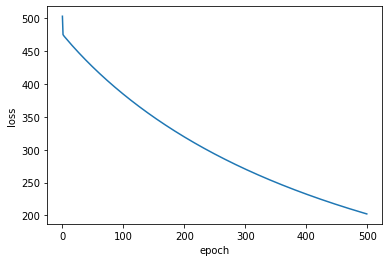

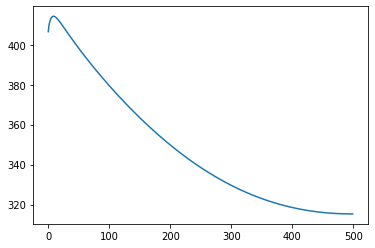

In [15]:
plt.plot(loss_log)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

plt.plot(loss_v_log)

In [16]:
# test (F)
running_test_loss = 0.0
for i, data in enumerate(Fdata_set):
    x_test, y_test = data
    with torch.no_grad():
        pred = model_cls(x_test)
        loss = criterion(pred, y_test)
        running_test_loss += loss.item()
        print(pred,y_test)
print(running_test_loss/10)

tensor([4.9653], device='cuda:0') tensor(29., device='cuda:0')
tensor([4.9653], device='cuda:0') tensor(15., device='cuda:0')
tensor([4.9653], device='cuda:0') tensor(25., device='cuda:0')
tensor([4.9653], device='cuda:0') tensor(14., device='cuda:0')
tensor([1.5914], device='cuda:0') tensor(18., device='cuda:0')
tensor([3.8106], device='cuda:0') tensor(8., device='cuda:0')
tensor([3.1403], device='cuda:0') tensor(-31., device='cuda:0')
tensor([-2.1335], device='cuda:0') tensor(-20., device='cuda:0')
tensor([-10.0981], device='cuda:0') tensor(-20., device='cuda:0')
tensor([0.3355], device='cuda:0') tensor(-24., device='cuda:0')
362.32068901062013
